In [2]:
!pip install jieba wordcloud pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
      --------------------------------------- 0.3/19.2 MB ? eta -:--:--
     - -------------------------------------- 0.5/19.2 MB 1.4 MB/s eta 0:00:14
     - -------------------------------------- 0.5/19.2 MB 1.4 MB/s eta 0:00:14
     - -------------------------------------- 0.5/19.2 MB 1.4 MB/s eta 0:00:14
     - -------------------------------------- 0.5/19.2 MB 1.4 MB/s eta 0:00:14
     - ------------------------------------- 0.8/19.2 MB 520.2 kB/s eta 0:00:36
     - ------------------------------------- 0.8/19.2 MB 520.2 kB/s eta 0:00:36
     -- ------------------------------------ 1.0/19.2 MB 491.5 kB/s eta 0:00:37
     -- ------------------------------------ 1.0/19.2 MB 491.5 kB/s eta 0:00:37
     -- ------------------------------------ 1.0/19.2 MB 491.5 kB/s et

  DEPRECATION: Building 'jieba' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'jieba'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


正在执行数据修正与趋势预测...

--- [原始] 每月发帖量 ---
发布时间
2025-06-30    1522
2025-07-31    1036
2025-08-31    1410
2025-09-30     961
2025-10-31     824
2025-11-30     686
Freq: ME, dtype: int64

>>> 执行修正逻辑：
    11月原始数据 (截止23日): 686
    全月预估 (30天): 894

--- [修正后] 用于训练的数据 ---
发布时间
2025-06-30    1522
2025-07-31    1036
2025-08-31    1410
2025-09-30     961
2025-10-31     824
2025-11-30     894
Freq: ME, dtype: int64

【预测结果】基于修正后的趋势，12月预测值为: 685
图表已保存: D:\5507课件\作业\泡泡玛特_修正后预测图.png


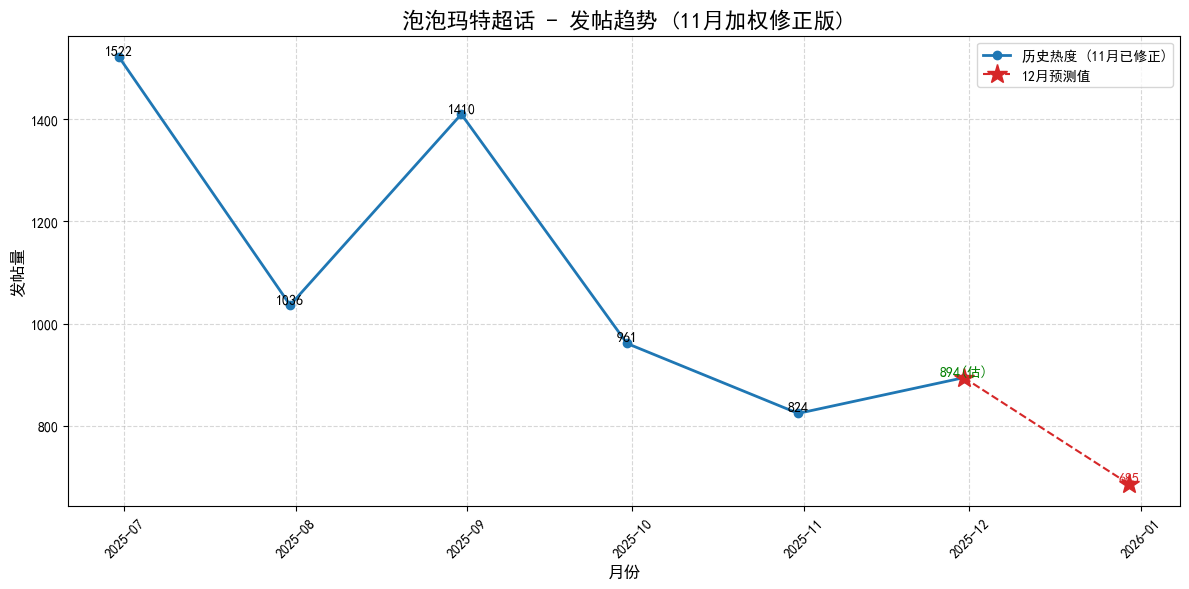

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
from sklearn.linear_model import LinearRegression

# --- 1. 配置区域 ---
FILE_PATH = r"D:\5507课件\作业\ppmt超话帖子_清洗版.csv"
SAVE_DIR = os.path.dirname(FILE_PATH)

# 中文设置
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

def predict_with_correction(df):
    print("正在执行数据修正与趋势预测...")
    
    # 1. 数据预处理
    df['发布时间'] = pd.to_datetime(df['发布时间'], errors='coerce')
    df = df.dropna(subset=['发布时间'])
    
    # 2. 按月统计原始数据
    monthly_data = df.set_index('发布时间').resample('ME').size()
    
    print("\n--- [原始] 每月发帖量 ---")
    print(monthly_data)
    
    # =======================================================
    # 3. 核心步骤：11月数据修正 (加权补全)
    # =======================================================
    try:
        # 显式查找 2025-11 的数据
        target_month_idx = pd.Timestamp('2025-11-30')
        if target_month_idx in monthly_data.index:
            raw_nov_count = monthly_data[target_month_idx]
            
            # 算法：824 / 23 * 30
            days_captured = 23
            days_in_month = 30
            
            # 计算修正值
            corrected_nov_count = int(raw_nov_count / days_captured * days_in_month)
            
            print(f"\n>>> 执行修正逻辑：")
            print(f"    11月原始数据 (截止23日): {raw_nov_count}")
            print(f"    全月预估 (30天): {corrected_nov_count}")
            
            # 更新数据用于训练模型
            monthly_data[target_month_idx] = corrected_nov_count
        else:
            print("警告：数据中未找到2025年11月的数据，无法修正。")
    except Exception as e:
        print(f"修正过程出错: {e}")

    # --- 这里就是你报错的地方，请确保这一行是完整的 ---
    print("\n--- [修正后] 用于训练的数据 ---")
    print(monthly_data)

    # =======================================================
    # 4. 线性回归预测
    # =======================================================
    X = np.arange(len(monthly_data)).reshape(-1, 1)
    y = monthly_data.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 预测下一个月 (12月)
    next_month_index = np.array([[len(monthly_data)]])
    pred_value = int(max(0, model.predict(next_month_index)[0]))
    
    print(f"\n【预测结果】基于修正后的趋势，12月预测值为: {pred_value}")

    # =======================================================
    # 5. 绘图
    # =======================================================
    plt.figure(figsize=(12, 6))
    
    dates = monthly_data.index
    next_date = dates[-1] + pd.DateOffset(months=1) # 12月日期
    
    # A. 画历史趋势
    plt.plot(dates, y, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='历史热度 (11月已修正)')
    
    # B. 画预测线
    plt.plot([dates[-1], next_date], [y[-1], pred_value], 
             linestyle='--', color='#d62728', marker='*', markersize=15, label='12月预测值')
    
    # C. 设置X轴格式
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # 图表装饰
    plt.title('泡泡玛特超话 - 发帖趋势 (11月加权修正版)', fontsize=16)
    plt.xlabel('月份', fontsize=12)
    plt.ylabel('发帖量', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.legend()
    
    # 标注数值
    for d, v in zip(dates, y):
        if d.month == 11:
            plt.text(d, v, f"{v}(估)", ha='center', va='bottom', fontsize=10, fontweight='bold', color='green')
        else:
            plt.text(d, v, str(v), ha='center', va='bottom', fontsize=10)
            
    plt.text(next_date, pred_value, str(pred_value), ha='center', va='bottom', fontsize=10, color='#d62728', fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(SAVE_DIR, '泡泡玛特_修正后预测图.png')
    plt.savefig(save_path, dpi=300)
    print(f"图表已保存: {save_path}")
    plt.show()

def main():
    if not os.path.exists(FILE_PATH):
        print(f"文件不存在: {FILE_PATH}")
        return
    
    try:
        df = pd.read_csv(FILE_PATH, encoding='utf-8-sig')
    except:
        df = pd.read_csv(FILE_PATH, encoding='gbk')
    
    if '发布时间' in df.columns:
        predict_with_correction(df)
    else:
        print("数据缺失'发布时间'列，无法分析。")

if __name__ == "__main__":
    main()

正在处理文本...
正在进行分词...
正在绘制词云图 (已隐藏品牌词)...
生成完成！图片已保存至: D:\5507课件\作业\泡泡玛特_去品牌词_词云图.png


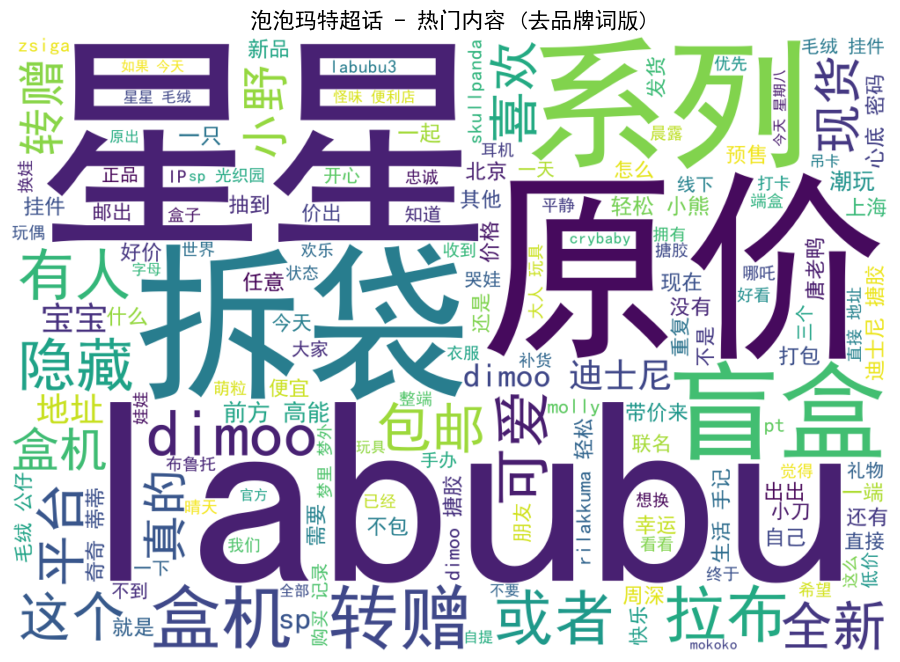

In [ ]:
import pandas as pd
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# --- 1. 配置区域 ---
FILE_PATH = r"D:\5507课件\作业\ppmt超话帖子_清洗版.csv"
SAVE_DIR = os.path.dirname(FILE_PATH)

# 设置中文字体 (用于Matplotlib标题显示)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def generate_visual_wordcloud(df):
    print("正在处理文本...")
    
    # 1. 提取所有微博内容
    # astype(str) 确保所有内容转为字符串，防止报错
    text_content = " ".join(df['微博内容'].astype(str).tolist())
    
    # 2. 【核心步骤】定义要屏蔽的词 (停用词)
    # 在这里把不想在图里看到的词都写进去
    stop_words = {
        # --- 必须屏蔽的品牌词 ---
        "泡泡玛特", "泡泡玛特超话", "超话", "拆盒", "拆袋"
        "泡泡", "玛特", "POPMART", "POP MART", "popmart","泡泡", 
        
        # --- 常见的无意义虚词 (建议保留，否则图里全是"的"、"了") ---
        "的", "了", "在", "是", "我", "有", "和", "就", "不", "人", "都", "一", "一个", "上", "也", "很", "到", "说", "去", "点",
        "展开", "全文", "网页", "链接", "微博", "视频", "查看", "图片", "评论", "转发", "赞",
        "好", "吗", "吧", "啊", "呢", "嘛", "哈", "这里", "私", "带价", "可以", "想要", "最好", "两个", "但是", "有没有", "不要",
    }
    
    # 3. 中文分词
    print("正在进行分词...")
    # 使用结巴分词把句子切开
    words = jieba.lcut(text_content)
    
    # 4. 拼接文本 (WordCloud库会自动根据 stop_words 过滤)
    # 这里我们只做一个简单的长度过滤，去掉单个字的词（通常没意义）
    processed_text = " ".join([w for w in words if len(w) > 1])
    
    # 5. 生成词云
    print("正在绘制词云图 (已隐藏品牌词)...")
    
    # 注意：Windows系统必须指定中文字体路径，否则是方框
    wc = WordCloud(
        font_path=r"C:\Windows\Fonts\simhei.ttf", 
        width=1000, 
        height=700,
        background_color='white', # 背景颜色
        max_words=150,            # 图上最多显示多少个词
        colormap='viridis',       # 配色方案
        stopwords=stop_words,     # <--- 【关键】把屏蔽词传给词云生成器
        random_state=42
    ).generate(processed_text)
    
    # 6. 显示与保存
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') # 关掉坐标轴
    plt.title('泡泡玛特超话 - 热门内容 (去品牌词版)', fontsize=16)
    
    save_path = os.path.join(SAVE_DIR, '泡泡玛特_去品牌词_词云图.png')
    wc.to_file(save_path)
    
    print(f"生成完成！图片已保存至: {save_path}")
    plt.show()

def main():
    if not os.path.exists(FILE_PATH):
        print(f"错误：找不到文件 {FILE_PATH}")
        return

    try:
        # 读取csv
        df = pd.read_csv(FILE_PATH, encoding='utf-8-sig')
    except:
        try:
            df = pd.read_csv(FILE_PATH, encoding='gbk')
        except Exception as e:
            print(f"读取失败: {e}")
            return
            
    if '微博内容' in df.columns:
        generate_visual_wordcloud(df)
    else:
        print("CSV中没有 '微博内容' 列，无法生成。")

if __name__ == "__main__":
    main()